# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.5672],
         [0.3107]]),
 tensor([[1.0000e+00, 5.6716e-01, 1.6083e-01, 3.0406e-02, 4.3112e-03, 4.8903e-04,
          4.6226e-05, 3.7453e-06, 2.6552e-07, 1.6733e-08, 9.4900e-10, 4.8930e-11,
          2.3126e-12, 1.0089e-13, 4.0872e-15, 1.5454e-16, 5.4780e-18, 1.8276e-19,
          5.7585e-21, 1.7189e-22],
         [1.0000e+00, 3.1069e-01, 4.8265e-02, 4.9986e-03, 3.8826e-04, 2.4126e-05,
          1.2493e-06, 5.5450e-08, 2.1535e-09, 7.4342e-11, 2.3098e-12, 6.5239e-14,
          1.6891e-15, 4.0369e-17, 8.9589e-19, 1.8557e-20, 3.6034e-22, 6.5856e-24,
          1.1367e-25, 1.8588e-27]]),
 tensor([5.2908, 5.2689]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.9943314  1.2159296 -3.42198    5.575901 ]]


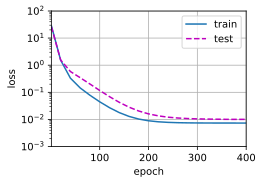

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.8630779 4.367253 ]]


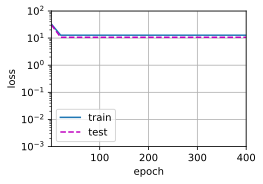

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9892683e+00  1.2703071e+00 -3.4137123e+00  5.2988524e+00
  -2.8754217e-03  8.2522362e-01  2.2768769e-01 -5.8838025e-02
   6.4528495e-02  5.5022761e-02 -1.9300265e-03  4.5678705e-02
  -5.9468493e-02  1.7602576e-01 -2.0718035e-01 -1.0302469e-01
  -4.9952816e-02  1.9603901e-01  4.7327235e-02 -5.6051984e-02]]


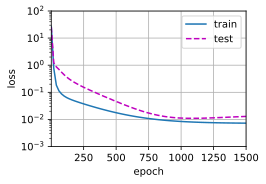

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)